In [ ]:
!git clone https://github.com/ladyduam1515/NLP.git

Cloning into 'NLP'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 160 (delta 35), reused 0 (delta 0), pack-reused 97
Receiving objects: 100% (160/160), 9.14 MiB | 10.42 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [ ]:
! ls

NLP  sample_data


In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from collections import Counter, defaultdict
#import tokenization
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

import operator

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

import gc

In [ ]:
df = pd.read_csv("/content/NLP/ReinaValera160V1.csv",delimiter="|",encoding="latin1")
df.head(10)

,Libro,Versiculo,Verso,Testamento
0,GÉNESIS,Gén.1.1.,En el principio creó Dios los cielos y la tier...,Antiguo
1,GÉNESIS,Gén.1.2.,"Y la tierra estaba desordenada y vacía, y las ...",Antiguo
2,GÉNESIS,Gén.1.3.,Y dijo Dios: Sea la luz; y fue la luz.,Antiguo
3,GÉNESIS,Gén.1.4.,Y vio Dios que la luz era buena; y separó Dios...,Antiguo
4,GÉNESIS,Gén.1.5.,"Y llamó Dios a la luz Día, y a las tinieblas l...",Antiguo
5,GÉNESIS,Gén.1.6.,Luego dijo Dios: Haya expansión en medio de la...,Antiguo
6,GÉNESIS,Gén.1.7.,"E hizo Dios la expansión, y separó las aguas q...",Antiguo
7,GÉNESIS,Gén.1.8.,Y llamó Dios a la expansión Cielos. Y fue la t...,Antiguo
8,GÉNESIS,Gén.1.9.,Dijo también Dios: Júntense las aguas que está...,Antiguo
9,GÉNESIS,Gén.1.10.,"Y llamó Dios a lo seco Tierra, y a la reunión ...",Antiguo


In [ ]:
print("The number of rows: " + format(df.shape[0]) + " The number of factors: " + format(df.shape[1]))

The number of rows: 31100 The number of factors: 4


In [ ]:
df["Libro"].unique()

array(['GÉNESIS', 'ÉXODO ', 'LEVÍTICO', 'NÚMEROS ', 'DEUTERONOMIO ',
       'JOSUÉ', 'JUECES ', 'RUT ', '1 SAMUEL ', '2 SAMUEL ', '1 REYES ',
       '2 REYES ', '1 CRÓNICAS ', '2 CRÓNICAS ', 'ESDRAS ', 'NEHEMÍAS ',
       'ESTER ', 'JOB ', 'SALMOS', 'PROVERBIOS ',
       'ECLESIASTÉS [o EL PREDICADOR] ',
       'CANTAR DE LOS CANTARES DE SALOMÓN ', 'ISAÍAS ', 'JEREMÍAS ',
       'LAMENTACIONES DE JEREMÍAS ', 'EZEQUIEL ', 'DANIEL ', 'OSEAS ',
       'JOEL ', 'AMÓS ', 'ABDÍAS ', 'JONÁS ', 'MIQUEAS ', 'NAHUM ',
       'HABACUC ', 'SOFONÍAS ', 'HAGEO ', 'ZACARÍAS ', 'MALAQUÍAS ',
       'SAN MATEO', 'SAN MARCOS ', 'SAN LUCAS ', 'SAN JUAN ',
       'HECHOS DE LOS APÓSTOLES ', 'ROMANOS ', '1 CORINTIOS ',
       '2 CORINTIOS ', 'GÁLATAS ', 'EFESIOS ', 'FILIPENSES ',
       'COLOSENSES ', '1 TESALONICENSES ', '2 TESALONICENSES ',
       '1 TIMOTEO ', '2 TIMOTEO ', 'TITO ', 'FILEMÓN ', 'HEBREOS ',
       'SANTIAGO ', '1 PEDRO ', '2 PEDRO ', '1 JUAN ', '2 JUAN ',
       '3 JUAN ', 'SAN JUDAS ', 

In [ ]:
import nltk
nltk.download('stopwords')
sw = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
sw = stopwords.words('spanish')

In [ ]:
import re
import string
def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub('\[.*?¿\]\%', ' ', texto)
    texto = re.sub('[%s]' % re.escape(string.puntuacion), ' ', texto)
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in sw])
    return texto

In [ ]:
df['limpio']=pre_procesado(df.Verso)

In [ ]:
df['NoWords'] = df['Verso'].str.split().str.len()

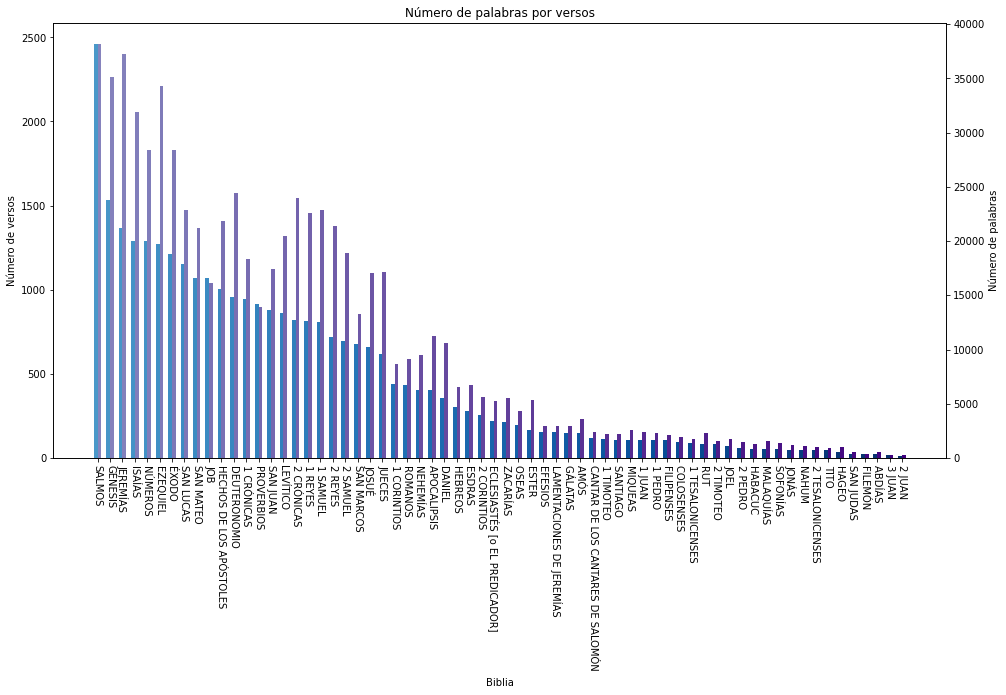

In [ ]:
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

words_versets = df.groupby('Libro').agg({'Versiculo':'count','NoWords':'sum'}).sort_values(by='Versiculo',ascending=False)
data1 = words_versets['Versiculo']
data2 = words_versets['NoWords']

plt.figure(figsize=(16,8))
x = np.arange(66)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Número de palabras por versos')
plt.xticks(x + w /2, data1.index, rotation=-90)
ax1.set_xlabel('Biblia')
ax1.set_ylabel('Número de versos')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel('Número de palabras')
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

In [ ]:
ps = PorterStemmer()

def lower_column_t(data):
    values = data['t']
    values = values.lower()
    data['t'] = values
    return data

def clean_interpunction(data):
    values = data['t']
    values = values.replace('.','')
    values = values.replace(';','')
    values = values.replace(':','')
    values = values.replace(',','')
    values = values.replace("'","")
    values = values.replace('"','')
    data['t'] = values
    return data

def stem(a):
    p = nltk.PorterStemmer()
    b = []
    for line in a:

        split_line = line.split(' ')
        length=len(split_line)
        new_line = []

        for word in range(length):
            if word == 0:
                new_line.append(str(p.stem(split_line[word])))
            else:
                new_line[0] = new_line[0] + ' ' + (str(p.stem(split_line[word])))

        b.append(new_line[0])

    return b

def lem(a):
    p = nltk.WordNetLemmatizer()
    b = []
    for line in a:

        split_line = line.split(' ')
        length=len(split_line)
        new_line = []

        for word in range(length):
            if word == 0:
                new_line.append(str(p.lemmatize(split_line[word], pos="v")))
            else:
                new_line[0] = new_line[0] + ' ' + (str(p.lemmatize(split_line[word], pos="v")))

        b.append(new_line[0])

    return b

def tokenize(a):  
    b = []
    for line in a:
        b.append(word_tokenize(line))
                 
    return b

def flatten(a):
    b = []
    for line in a:
        b = ' '.join(line)
    
    return b

def count_words(a):
    b=0
    for line in a:
        b = b + sum([i.strip(string.punctuation).isalpha() for i in line.split()])
        
    return b

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in sw]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

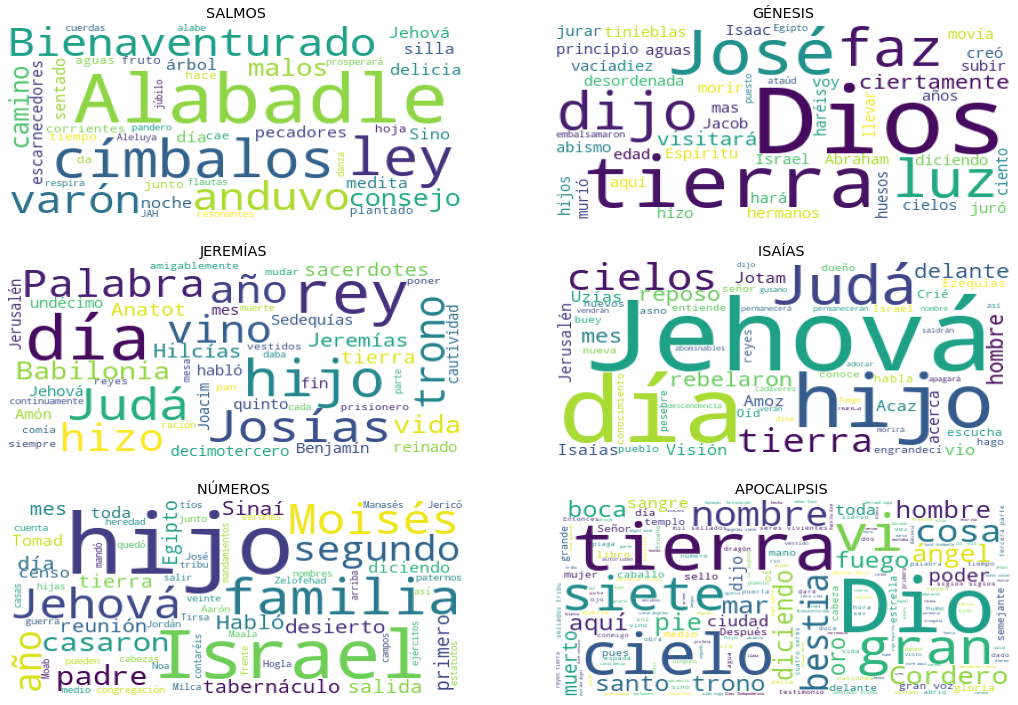

In [ ]:
mpl.rcParams['figure.figsize']=(10,10)    
mpl.rcParams['font.size']=12                        
mpl.rcParams['figure.subplot.bottom']=.1 

#movies.loc[movies.duration>200, ‘genre’]
libro0='SALMOS'
libro1='GÉNESIS'
libro2='JEREMÍAS '
libro3='ISAÍAS '
libro4='NÚMEROS '
libro5='APOCALIPSIS '

wordcloud_lb0 = WordCloud(background_color='white',stopwords=sw).generate(str(df.loc[df.Libro==libro0,['Verso']].values))
wordcloud_lb1 = WordCloud(background_color='white',stopwords=sw).generate(str(df.loc[df.Libro==libro1,['Verso']].values))
wordcloud_lb2 = WordCloud(background_color='white',stopwords=sw).generate(str(df.loc[df.Libro==libro2,['Verso']].values))
wordcloud_lb3 = WordCloud(background_color='white',stopwords=sw).generate(str(df.loc[df.Libro==libro3,['Verso']].values))
wordcloud_lb4 = WordCloud(background_color='white',stopwords=sw).generate(str(df.loc[df.Libro==libro4,['Verso']].values))
wordcloud_lb5 = WordCloud(background_color='white',stopwords=sw).generate(str(df.loc[df.Libro==libro5,['Verso']].values))


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
ax0, ax1, ax2, ax3,ax4,ax5= ax.flatten()

ax0.imshow(wordcloud_lb0, aspect="auto")
ax0.title.set_text(libro0)
ax0.axis('off')

ax1.imshow(wordcloud_lb1, aspect="auto")
ax1.title.set_text(libro1)
ax1.axis('off')

ax2.imshow(wordcloud_lb2, aspect="auto")
ax2.title.set_text(libro2)
ax2.axis('off')

ax3.imshow(wordcloud_lb3, aspect="auto")
ax3.title.set_text(libro3)
ax3.axis('off')

ax4.imshow(wordcloud_lb4, aspect="auto")
ax4.title.set_text(libro4)
ax4.axis('off')

ax5.imshow(wordcloud_lb5, aspect="auto")
ax5.title.set_text(libro5)
ax5.axis('off')

plt.show()

Utilizo vectorizador y descomposición de valores singulares para crear grupos de texto y fusionarlos con los datos:

In [ ]:
vectorizer = TfidfVectorizer(max_df = 0.5, max_features = 1000)
X = vectorizer.fit_transform(df.Verso)

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X = svd.fit_transform(X)

cluster_data = pd.DataFrame({'Comp1': X[:,0], 'Comp2': X[:,1],'Testamento':df.Testamento, 'Libro':df.Libro , 'Verso':df.Verso, 'Versiculo':df.Versiculo, 'NoWords':df.NoWords})
cluster_data.head()

,Comp1,Comp2,Testamento,Libro,Verso,Versiculo,NoWords
0,0.292937,0.100116,Antiguo,GÉNESIS,En el principio creó Dios los cielos y la tier...,Gén.1.1.,10
1,0.252819,0.008899,Antiguo,GÉNESIS,"Y la tierra estaba desordenada y vacía, y las ...",Gén.1.2.,29
2,0.159653,-0.048506,Antiguo,GÉNESIS,Y dijo Dios: Sea la luz; y fue la luz.,Gén.1.3.,10
3,0.180473,-0.028957,Antiguo,GÉNESIS,Y vio Dios que la luz era buena; y separó Dios...,Gén.1.4.,16
4,0.168286,-0.014734,Antiguo,GÉNESIS,"Y llamó Dios a la luz Día, y a las tinieblas l...",Gén.1.5.,22


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


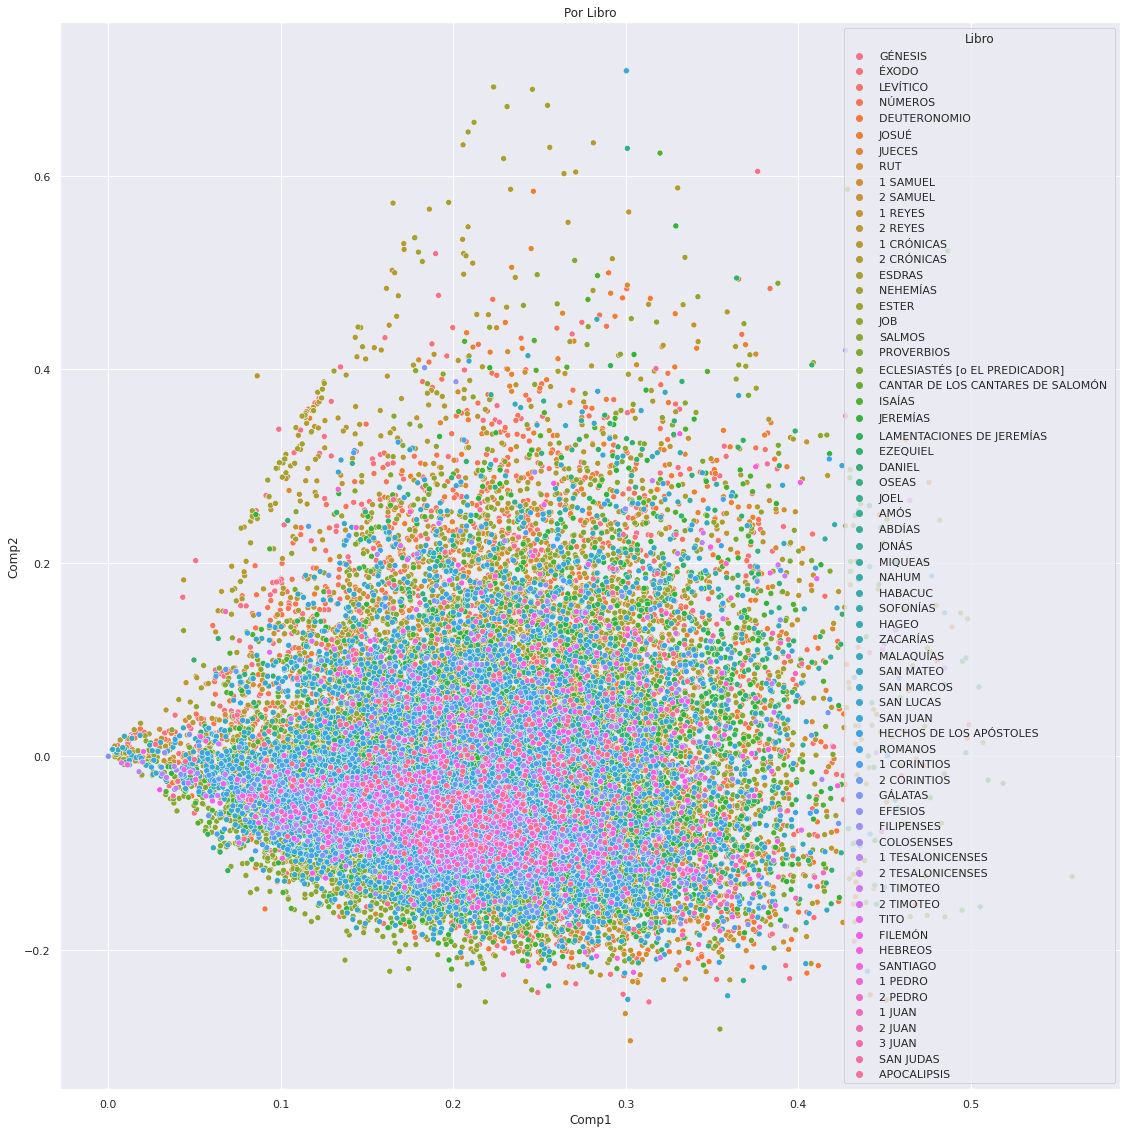

In [ ]:
sns.set(rc={'figure.figsize':(19, 19)})
sns.scatterplot('Comp1', 'Comp2', data=cluster_data, hue='Libro').set_title('Por Libro')
plt.show()